# Speech Elements

## Preparing

In [1]:
import spacy
from spacy.matcher import Matcher
import pandas as pd
import re
import os
import nltk
import textacy
from collections import Counter
import contractions
import matplotlib.pyplot as plt
import altair as alt
import numpy as np

Read in data

In [2]:


# import clean scripts (character names are removed too)
all_scripts = pd.read_pickle("all_scripts_cleaned_total-99.pickle")
# import spacy english dict 
nlp = spacy.load('en_core_web_sm')

/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
# run nlp spacy on all lines
nlp_sentences = []
for sentence in all_scripts['Clean_Line_all']:
    doc=nlp(sentence)
    nlp_sentences.append(doc)
    
all_scripts['line_NLP'] = nlp_sentences

## Verbs in Sentences

In [4]:
# SAVE VERBS IN A COLUMN

list_of_verbs = []
# patterns for verbs 
patterns = [[{"POS": "VERB"}], [{"POS": "AUX"}]]

# extract verbs
for sentence in all_scripts['line_NLP']:
    verbs = textacy.extract.matches.token_matches(sentence, patterns=patterns)
    all_verbs = []
    for verb in verbs:
        verb = str(verb) 
        all_verbs.append(verb)
    list_of_verbs.append(all_verbs)
        
# storing the result in a new file and converting to csv
all_scripts['Verbs'] = list_of_verbs

In [5]:
# count words and verbs in sentences 
all_scripts['Verbs_n'] = all_scripts['Verbs'].str.len()
all_scripts['line_split'] = all_scripts['Clean_Line_all'].str.split()
all_scripts['Words_n'] = all_scripts['line_split'].str.len()

## Modal Verbs
Analysis of modal verbs is a particular area in lingustics, where modal sense of the sentence is determined

Modality is about a speaker’s or a writer’s attitude towards the world. A speaker or writer can express certainty, possibility, willingness, obligation, necessity and ability by using modal words and expressions.

There are nine modal auxiliary verbs: **shall, should, can, could, will, would, may, must, might.**

Semi-modals: **dare, need, ought to, used to**

In [6]:
# list of modals 
modals = ['shall', 'should', 'can', 'could', 'will', 'would', 'may', 'must', 'might']

# count number of modal verbs for all sentences 
modals_count = []
for list_of_verbs in all_scripts['Verbs']:
    count = 0
    for word in list_of_verbs:
        if word in modals:
            count += 1
    modals_count.append(count)
    
all_scripts['Modal_verbs'] = modals_count

In [7]:
sum_lines = all_scripts.groupby(['Gender']).sum().reset_index()

In [8]:
#Calculate procent of verbs and the share of verbs that are modal verbs
all_scripts['Verbs_pct'] = all_scripts['Verbs_n'] / all_scripts['Words_n']
all_scripts['Modals_pct'] = all_scripts['Modal_verbs'] /all_scripts['Verbs_n']

In [9]:
#mean model verbs in procent 
mean_modal = all_scripts[['Modals_pct','Gender']].groupby('Gender').mean()*100
mean_modal = mean_modal.reset_index()
mean_modal = mean_modal.iloc[::-1]

In [10]:
mean_modal

,Gender,Modals_pct
1,Male,6.235383
0,Female,7.255980


### Plotting model verbs for men and women 

In [11]:
colors = ["#3e1e58", "#fce43c", "#98c862", "#4c8e70"]


/var/folders/f1/s37s84893rx20wc3fwvjlf2m0000gn/T/ipykernel_17730/2797542718.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Men', 'Women'], fontsize=12, rotation=0)
/var/folders/f1/s37s84893rx20wc3fwvjlf2m0000gn/T/ipykernel_17730/2797542718.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Men', 'Women'], fontsize=12, rotation=0)


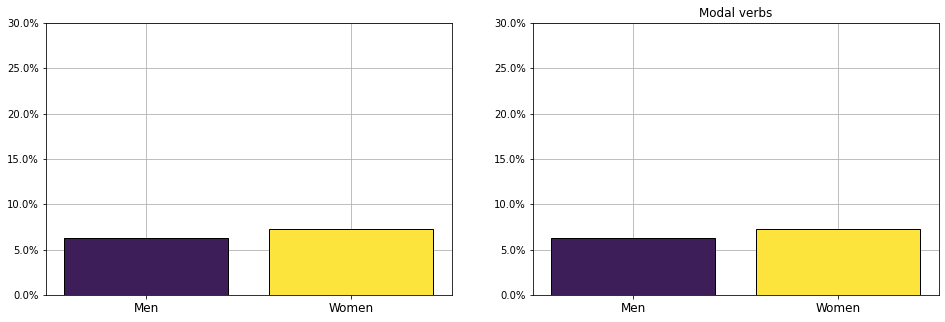

In [12]:
# plot figure of subplots 
fig1, [ax1, ax2] = plt.subplots(1, 2, figsize = (16, 5))

# plot 1
ax1.bar(mean_modal['Gender'], mean_modal['Modals_pct'],edgecolor='black', 
        color = colors, zorder = 3)

# plot 2 
ax2.bar(mean_modal['Gender'], mean_modal['Modals_pct'],edgecolor='black', 
        color = colors, zorder = 3)

# formatting
import matplotlib.ticker as mtick
ax1.yaxis.set_major_formatter(mtick.PercentFormatter()) # set percentage at yaxis.
ax2.yaxis.set_major_formatter(mtick.PercentFormatter()) # set percentage at yaxis.

ax1.set_xticklabels(['Men', 'Women'], fontsize=12, rotation=0)
ax1.set_ylim([0, 30])

ax2.set_xticklabels(['Men', 'Women'], fontsize=12, rotation=0)
ax2.set_ylim([0, 30])
ax2.set_title('Modal verbs')

ax1.grid(True)
ax2.grid(True)

#plt.show()
plt.savefig('modal.png',bbox_inches='tight')

In [20]:
# create for loop for testing z-test
import statsmodels.api as sm

# list of columns we want to test 
test_list = ['Modal_verbs']
z_test_results = []
m_mean = []
w_mean = []

for column in test_list:
    column = column
    male = all_scripts.query('Gender == "Male"')[column] 
    male = sm.stats.DescrStatsW(male)
    male_mean = all_scripts.loc[all_scripts['Gender'] == 'Male'][column].mean()
    m_mean.append(male_mean)
    female = all_scripts.query('Gender == "Female"')[column]
    female = sm.stats.DescrStatsW(female)
    female_mean = all_scripts.loc[all_scripts['Gender'] == 'Female'][column].mean()
    w_mean.append(female_mean)
    z_test = sm.stats.CompareMeans(male, female).ztest_ind(usevar='unequal',value=0)
    z_test_results.append(z_test)
    
test_df = pd.DataFrame(
    {'Speech element': test_list,
     'Mean for men': m_mean,
     'Mean for women': w_mean,
     'Z_test': z_test_results,
    })

In [21]:
test_df

,Speech element,Mean for men,Mean for women,Z_test
0,Modal_verbs,0.197766,0.219585,"(-3.5776489853454976, 0.0003466986100185891)"


### Plotting eras and modal verbs for men and women

In [16]:
#Adding letters to era to make sure they are alphabetically listed 
all_scripts['Era'] = all_scripts['Era'].replace({'The Golden Age': 'A The Golden Age', 'The Bronze Age': 'B The Bronze Age', 'The Disney Renaissance': 'C The Disney Renaissance', 
                               'Post Renaissance Era': 'D Post Renaissance Era','The Revival Era': 'E The Revival Era',
                               'Present period': 'F Present period'})

In [23]:
#Function words across Era 
import matplotlib.ticker as mtick
df_women = all_scripts[all_scripts.Gender == 'Female']
df_men = all_scripts[all_scripts.Gender == 'Male']

mean_mod_era_female = df_women[['Modals_pct','Era']].groupby('Era').mean()*100
mean_mod_era_male = df_men[['Modals_pct','Era']].groupby('Era').mean()*100

In [24]:
print(mean_mod_era_female)
print(mean_mod_era_male)

                          Modals_pct
Era                                 
A The Golden Age           10.425924
B The Bronze Age            8.383896
C The Disney Renaissance    8.464795
D Post Renaissance Era      5.987002
E The Revival Era           6.424235
F Present period            7.118239
                          Modals_pct
Era                                 
A The Golden Age            7.476257
B The Bronze Age            6.326775
C The Disney Renaissance    6.818401
D Post Renaissance Era      5.874427
E The Revival Era           5.753150
F Present period            5.795750


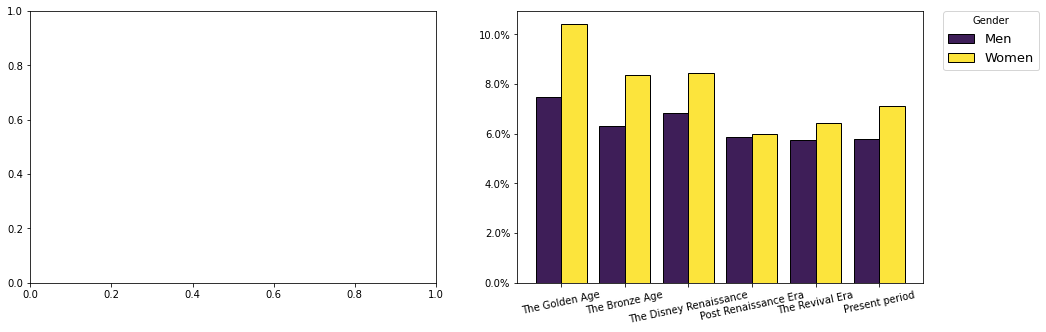

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
colors = ["#3e1e58", "#fce43c", "#98c862", "#4c8e70"]
xlabels = ['The Golden Age', 'The Bronze Age', 'The Disney Renaissance',
           'Post Renaissance Era', 'The Revival Era', 'Present period']
X = ['A The Golden Age', 'B The Bronze Age', 'C The Disney Renaissance', 'D Post Renaissance Era','E The Revival Era','F Present period']
Men = [7.476257,6.326775,6.818401,5.874427,5.753150, 5.795750]
Women = [10.425924,8.383896,8.464795, 5.987002,6.424235,7.118239]


X_axis = np.arange(len(X))

ax2.bar(X_axis - 0.2, Men, 0.4, label = 'Men', color ="#3e1e58",edgecolor='black', )
ax2.bar(X_axis + 0.2, Women, 0.4, label = 'Women',color ="#fce43c",edgecolor='black', )




# formatting
import matplotlib.ticker as mtick
ax2.yaxis.set_major_formatter(mtick.PercentFormatter()) # set percentage at yaxis.

#Setting ax labels
ax2.set_xticks(X_axis,xlabels, rotation = 12)

plt.legend(bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.,title='Gender', fontsize = 13)
#plt.show()
plt.savefig('modals for genderxera.png', bbox_inches='tight')